In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm
from tensorflow import keras 
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
import string
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')

In [3]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
data.shape

(41157, 6)

In [5]:
data["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [6]:
data.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
def transform(data):
    return (str(data["Location"]) + " " + str(data["Sentiment"]) + " " + str(data["OriginalTweet"]))

In [8]:
ndata = data.apply(transform, axis=1)

In [9]:
ndata

0        London Neutral @MeNyrbie @Phil_Gahan @Chrisitv...
1        UK Positive advice Talk to your neighbours fam...
2        Vagabonds Positive Coronavirus Australia: Wool...
3        nan Positive My food stock is not the only one...
4        nan Extremely Negative Me, ready to go at supe...
                               ...                        
41152    Wellington City, New Zealand Neutral Airline p...
41153    nan Extremely Negative Response to complaint n...
41154    nan Positive You know itÂs getting tough when...
41155    nan Neutral Is it wrong that the smell of hand...
41156    i love you so much || he/him Negative @TartiiC...
Length: 41157, dtype: object

In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

In [11]:
def process(s):
    for p in punctuation:
        s = s.replace(p, '')
    s = s.lower()
    s = word_tokenize(s)
    s = [w for w in s if not w in stop_words] #optional
    s = [stemmer.stem(word) for word in s]
    return s

In [12]:
from tqdm import tqdm

for i in tqdm(range(ndata.shape[0])):
    ndata[i] = process(ndata[i])

100%|██████████| 41157/41157 [00:23<00:00, 1778.96it/s]


In [13]:
for i in tqdm(range(ndata.shape[0])):
    ndata[i] = " ".join(ndata[i])

100%|██████████| 41157/41157 [00:00<00:00, 108076.57it/s]


In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer(max_features=20000)
tfidf = vectorizer.fit_transform(ndata).toarray()
features = vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(tfidf, columns=features)

In [16]:
tfidf

,00,000,00000000000000,000s,001,00am,00pm,01,010,0113,...,zp,zu,zuku,zukuoffici,zumbuehl,zummerzet,zurich,zweli,zã,zã¼rich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


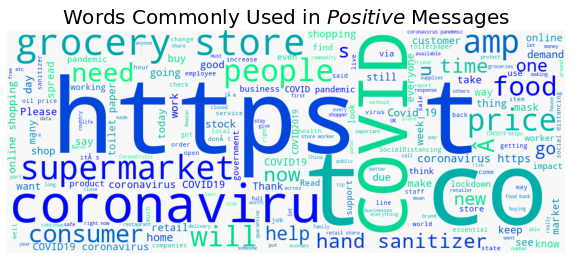

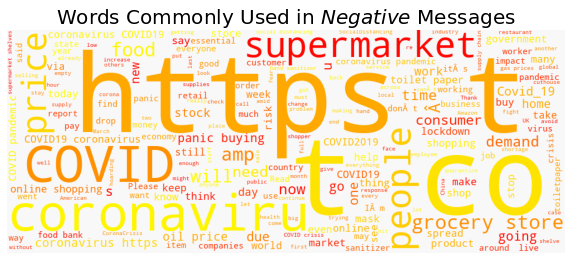

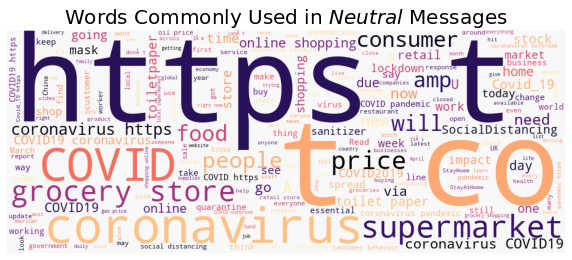

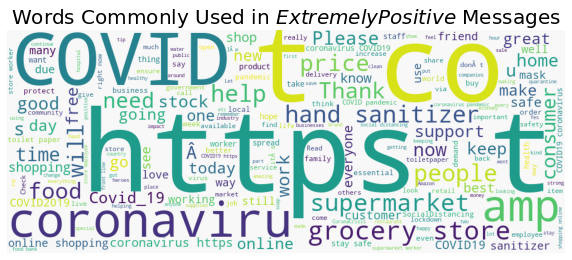

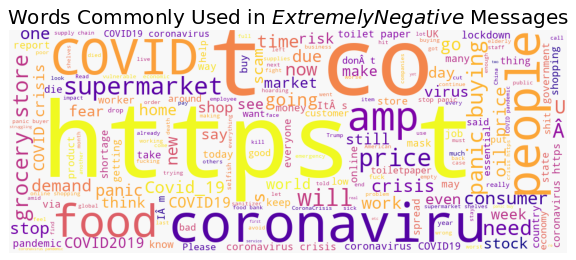

In [17]:
from wordcloud import WordCloud
for label, cmap in zip(['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative'],
                       ['winter', 'autumn', 'magma', 'viridis', 'plasma']):
    text = data.query('Sentiment == @label')['OriginalTweet'].str.cat(sep=' ')
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=400, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()